Predicting UP IR flux, large errors using very bad method, and purposefully messing up the inut and output times, so the ith time snapshot of input is trained against the i+1th time snapshot of output

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DS_a = xr.open_dataset('af') #dataset of auxhist
DS_w = xr.open_dataset('wf') #dataset of wrfout

In [3]:
#Temperature:
T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
T.shape

(71, 52, 36, 72)

In [4]:
T[5,:,18,0] #temperature goes from lowest height to highest height

array([242.71082 , 237.8069  , 236.24007 , 235.12848 , 234.2799  ,
       233.52779 , 232.82172 , 232.14073 , 231.47406 , 230.81564 ,
       229.99742 , 229.01949 , 228.03973 , 227.05513 , 225.73048 ,
       224.05423 , 220.9039  , 215.62561 , 209.97517 , 208.85222 ,
       206.90262 , 204.41917 , 200.12592 , 195.17355 , 189.94121 ,
       186.28903 , 183.58492 , 180.31416 , 176.13753 , 171.68274 ,
       167.32304 , 163.81029 , 160.24342 , 155.59138 , 150.58986 ,
       146.3529  , 142.94057 , 139.79279 , 136.59853 , 133.4877  ,
       131.82347 , 138.27815 , 160.04852 , 173.36342 , 169.7645  ,
       162.5508  , 155.04514 , 147.05397 , 139.96574 , 138.28108 ,
       119.210464, 138.57014 ], dtype=float32)

In [5]:
st = DS_w.TSK.values #surface temp
st.shape

(71, 36, 72)

In [6]:
d_c = DS_w.TAU_OD.values #dust optical depth
d_c.shape 

(71, 52, 36, 72)

In [7]:
em = DS_w.EMISS.values #emissivity
em.shape

(71, 36, 72)

In [8]:
uif = DS_a.UPIRFLUX.values[1:,10,:,:] #remove 1st snapshot since it contains all 0s
uif.shape

(70, 36, 72)

In [9]:
t_d = [] #total data
#input:
for k in range(70): #two errors cancel out...right!?
    for i in range(36):
        for j in range(72):
            input_array = list(T[k,:,i,j]) #start with temp profile
            input_array += list(d_c[k,:,i,j]) #add dust profile
            input_array.append(st[k,i,j])#add surface temp
            input_array.append(em[k,i,j]) #add emissivity
            input_array.append(uif[k,i,j])            
            t_d.append(input_array) #appends input to input array

In [10]:
t_d = np.array(t_d)
t_d.shape

(181440, 107)

In [11]:
uif_in = t_d[:,:106]
uif_out = t_d[:,106]

In [12]:
np.array_equal(uif[:,:,:].reshape(-1), t_d[:,106])

True

In [13]:
t_d[:,106].shape

(181440,)

# Trying linear regression first

In [14]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1.fit(uif_in,uif_out)
uif_lin = lr1.predict(uif_in) #predicted

In [15]:
lr1.coef_

array([ 1.12336612e+00, -1.77602887e+00,  1.58026338e-01, -3.23515236e-02,
        4.02387381e-01, -4.30133343e-02,  4.30076003e-01, -2.28693247e-01,
        2.14875072e-01,  1.34870434e+00, -1.45817733e+00, -3.77111644e-01,
        2.56378222e+00, -3.23123741e+00, -1.48355389e+00,  4.92932844e+00,
       -1.72439599e+00,  1.17643607e+00, -1.30080485e+00, -1.15567780e+00,
       -6.24534845e-01,  5.64591289e-01,  2.55918026e-01, -3.41108918e-01,
       -2.04410577e+00,  6.54986954e+00, -9.31236267e+00,  8.81986618e+00,
       -7.26856995e+00,  6.98110962e+00, -6.40444183e+00,  5.01331329e+00,
       -3.21263885e+00,  1.72594070e+00, -4.08339500e-03, -2.16599464e-01,
       -3.60563278e-01,  7.91855812e-01, -7.42094994e-01, -3.67177963e-01,
        1.10223961e+00, -7.69808769e-01,  1.81201935e-01,  8.85658264e-02,
       -3.58263493e-01,  4.91779327e-01, -5.34380674e-01,  6.62717819e-01,
       -6.84663057e-01,  6.20134354e-01, -3.56366396e-01,  4.23179150e-01,
        2.08947207e+04,  

In [16]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse #a lot higher!

20.946884

In [17]:
np.min(uif_out)

15.638899

In [18]:
np.max(uif_out)

412.3086

In [19]:
uif_diff = uif_out - uif_lin

In [20]:
np.where(uif_diff == np.min(uif_diff))

(array([1265], dtype=int64),)

In [21]:
uif_out[1265]

43.645775

In [22]:
uif_lin[1265] #reall pretty big differences...

125.3663

In [23]:
np.where(uif_diff > 50)

(array([   295,    360,    361, ..., 177629, 181025, 181026], dtype=int64),)

<function matplotlib.pyplot.show(*args, **kw)>

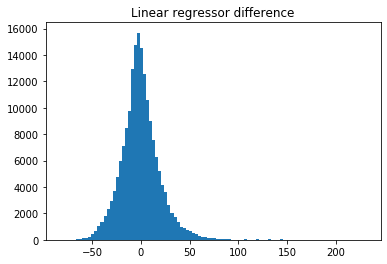

In [24]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #much larger variance than before...

In [25]:
uif_out.reshape(-1,1).shape

(181440, 1)

In [26]:
uif_in[:10*36*72,:].shape

(25920, 106)

In [27]:
uif_in[10*36*72:11*36*72,:]

array([[1.4613609e+02, 1.4618954e+02, 1.4609061e+02, ..., 2.0695563e-09,
        1.4552968e+02, 7.3600000e-01],
       [1.4615848e+02, 1.4621857e+02, 1.4612384e+02, ..., 2.0710489e-09,
        1.4553777e+02, 7.3600000e-01],
       [1.4617586e+02, 1.4624217e+02, 1.4615150e+02, ..., 2.0716873e-09,
        1.4554124e+02, 7.3600000e-01],
       ...,
       [2.0036565e+02, 2.0044133e+02, 2.0036389e+02, ..., 3.0959058e-09,
        1.9934549e+02, 1.0000000e+00],
       [2.0065401e+02, 2.0072145e+02, 2.0063800e+02, ..., 3.0965090e-09,
        1.9967104e+02, 1.0000000e+00],
       [2.0093640e+02, 2.0099574e+02, 2.0090686e+02, ..., 3.0970195e-09,
        1.9999327e+02, 1.0000000e+00]], dtype=float32)

In [28]:
real_out = uif_out[10*36*72:11*36*72].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72].reshape(36,72)

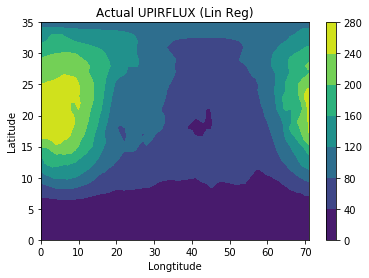

In [29]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

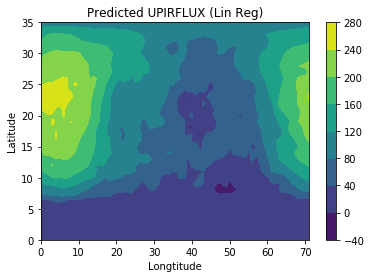

In [30]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

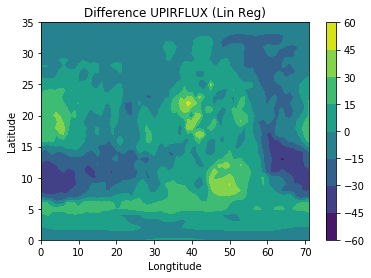

In [31]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

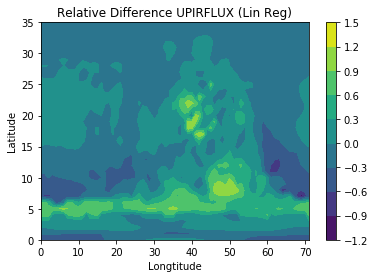

In [32]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

# Let's try random forest regressor:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rfr1 = RandomForestRegressor()
rfr1.fit(uif_in[:10*36*72,:],uif_out[:10*36*72]) #training set
uif_rfr = rfr1.predict(uif_in[10*36*72:11*36*72,:]) 

rfr_mse = mean_squared_error(uif_out[10*36*72:11*36*72], uif_rfr) #test the model on a single day
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse 

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
rfr_diff = uif_out[10*36*72:11*36*72] - uif_rfr

In [ ]:
plt.hist(rfr_diff, bins = 100)
plt.title("Random Forest Regressor Difference")
plt.show #still really good

In [ ]:
real_out = uif_out[10*36*72:11*36*72].reshape(36,72)
pred_out = uif_rfr.reshape(36,72)

In [ ]:
np.max(uif_out[10*36*72:11*36*72])

In [ ]:
np.array_equal(uif_rfr,pred_out.reshape(-1))

In [ ]:
real_out.shape

In [ ]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [ ]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [ ]:
real_out.shape

In [ ]:
rfr_int_err = int_err(uif_rfr, uif_out[10*36*72:11*36*72], pd.DataFrame(uif_rfr), 3.39e6) #make sure the errors work by integrating a sphere's surface
print("Random forest integration error:")
np.array(rfr_int_err)/(1.44e14) #really small!!

In [ ]:
lin_int_err = int_err(uif_lin[10*36*72:11*36*72], uif_out[10*36*72:11*36*72], pd.DataFrame(uif_rfr), 3.39e6) #make sure the errors work by integrating a sphere's surface
print("Linear regression integration error:")
np.array(lin_int_err)/(1.44e14) #even larger...